# Use the last 1 hour of prices to predict the price 1 hour into the future.

**Faeze Safari**

In [79]:
# from google.colab import drive
# drive.mount('/content/drive')

In [80]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score, r2_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Prep data

In [81]:
import pandas as pd

# Define the path to the CSV file
# file_path = '/content/drive/MyDrive/USDT-CNY_5Min-15days.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv("USDT-CNY_scraper (2).csv")


# Inspect column names first to confirm
print("Original DataFrame columns:", df.columns.tolist())


# Try to automatically detect time column
time_col_name = None
possible_time_cols = ['time', 'date', 'timestamp', df.columns[0]] # Add first column name as a fallback
for col in possible_time_cols:
    if col in df.columns:
        time_col_name = col
        break

if time_col_name is None:
    # If no common time column name is found, assume the first column is time
    time_col_name = df.columns[0]

# Try to automatically detect close price column
close_col_name = None
possible_close_cols = ['close', 'Close', 'PRICE', 'price']
for col in possible_close_cols:
    if col in df.columns:
        close_col_name = col
        break

if close_col_name is None:
    print("Warning: 'close' price column not found with common names. Please verify column names.")
    print("Available columns:", df.columns.tolist())
    # Fallback: if 'close' isn't found, try to use the second column as price if it's numeric.
    if len(df.columns) > 1 and pd.api.types.is_numeric_dtype(df.iloc[:, 1]):
        close_col_name = df.columns[1]
        print(f"Using '{close_col_name}' as the close price column.")
    else:
        raise ValueError("Could not determine 'close' price column. Please specify the correct column name.")

# Convert the detected time column to datetime objects
df[time_col_name] = pd.to_datetime(df[time_col_name])

# Select only the time column and the 'close' price column
time_series_df = df[[time_col_name, close_col_name]].copy()

# Rename columns for clarity
time_series_df.columns = ['datetime', 'close_price']

# Set the datetime column as the index for time series analysis
time_series_df = time_series_df.set_index('datetime')

print("\nDataFrame for time series analysis (first 5 rows):\n", time_series_df.head())

Original DataFrame columns: ['timestamp_utc', 'timestamp_local', 'Open', 'High', 'Low', 'Close', 'total_volume', 'market_cap']

DataFrame for time series analysis (first 5 rows):
                            close_price
datetime                              
2025-10-13 15:15:00+00:00     7.139717
2025-10-13 15:20:00+00:00     7.139487
2025-10-13 15:25:00+00:00     7.139631
2025-10-13 15:30:00+00:00     7.139498
2025-10-13 15:35:00+00:00     7.139532


In [82]:
# Target: close price exactly 1 hour ahead (1-hour forecast horizon) (12 × 5-minute intervals)
time_series_df['target_next_hour_price'] = time_series_df['close_price'].shift(-12)

In [83]:
time_series_df.head()

,close_price,target_next_hour_price
datetime,,
2025-10-13 15:15:00+00:00,7.139717,7.139373
2025-10-13 15:20:00+00:00,7.139487,7.139738
2025-10-13 15:25:00+00:00,7.139631,7.139834
2025-10-13 15:30:00+00:00,7.139498,7.139747
2025-10-13 15:35:00+00:00,7.139532,7.139479


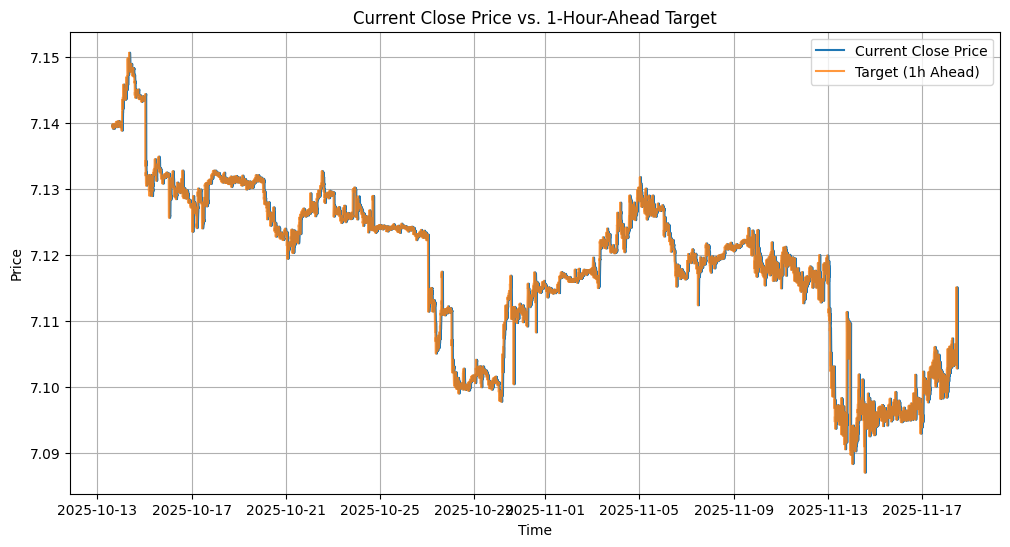

In [84]:
plt.figure(figsize=(12, 6))

plt.plot(time_series_df['close_price'],
         label='Current Close Price',
         alpha=1)

plt.plot(time_series_df['target_next_hour_price'],
         label='Target (1h Ahead)',
         alpha=0.8)

plt.title('Current Close Price vs. 1-Hour-Ahead Target')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

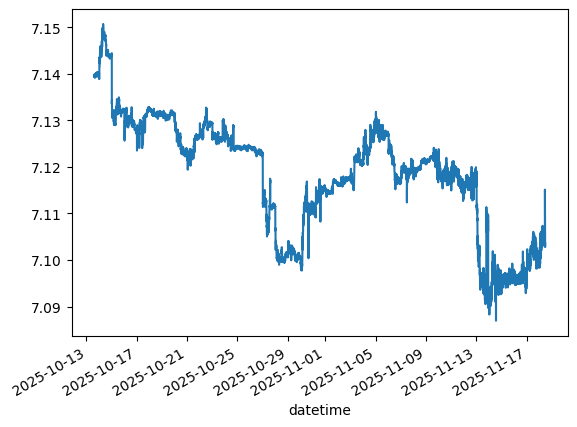

In [85]:
# visualize the data
time_series_df['target_next_hour_price'].plot()
plt.show()

In [86]:
# Create lag features representing the close_price values from the previous 2 hours before now.
# Since each row is 5 minutes apart, 2 hours = 24 rows.
# Lag_1  = price 5 minutes before now
# Lag_12 = price 1 hour before now
# Lag_24 = price 2 hours before now
# These lags give the model access to the recent price history leading up to the current timestamp,
# using only past information (no future leakage).
for i in range(1, 25):
    time_series_df[f'Lag_{i}'] = time_series_df['close_price'].shift(i)

print("df with lagged features (first 5 rows):")
time_series_df.head()

df with lagged features (first 5 rows):


,close_price,target_next_hour_price,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2025-10-13 15:15:00+00:00,7.139717,7.139373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:20:00+00:00,7.139487,7.139738,7.139717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:25:00+00:00,7.139631,7.139834,7.139487,7.139717,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:30:00+00:00,7.139498,7.139747,7.139631,7.139487,7.139717,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:35:00+00:00,7.139532,7.139479,7.139498,7.139631,7.139487,7.139717,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
time_series_df.shape

(10170, 26)

# Convert price col into sequences (We do not use the 'lag' colunms. We directly create them from the close_price using the function below.)

In [88]:
time_series_df.head()

,close_price,target_next_hour_price,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2025-10-13 15:15:00+00:00,7.139717,7.139373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:20:00+00:00,7.139487,7.139738,7.139717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:25:00+00:00,7.139631,7.139834,7.139487,7.139717,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:30:00+00:00,7.139498,7.139747,7.139631,7.139487,7.139717,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:35:00+00:00,7.139532,7.139479,7.139498,7.139631,7.139487,7.139717,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:  # The reason for -1 is because indexing in Python is zero-based, meaning the
		# last element of a list or array has an index of len(sequence) - 1. Therefore, if end_ix is greater than or
		# equal to len(sequence), it would indicate that the pattern extends beyond the end of the sequence.
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence.iloc[i:end_ix], sequence.iloc[end_ix]

		# if it was modeling for multivariate:
		# seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [90]:
n_steps = 12
raw_seq = time_series_df['close_price']
X, y = split_sequence(raw_seq, n_steps)

In [91]:
# check out X and y shape
print(time_series_df.shape)
print(X.shape)

(10170, 26)
(10158, 12)


In [92]:
X[:5]

array([[7.13971677, 7.1394872 , 7.13963069, 7.13949796, 7.13953164,
        7.13943762, 7.13949107, 7.13955654, 7.13964762, 7.13985408,
        7.13911634, 7.13953042],
       [7.1394872 , 7.13963069, 7.13949796, 7.13953164, 7.13943762,
        7.13949107, 7.13955654, 7.13964762, 7.13985408, 7.13911634,
        7.13953042, 7.13937333],
       [7.13963069, 7.13949796, 7.13953164, 7.13943762, 7.13949107,
        7.13955654, 7.13964762, 7.13985408, 7.13911634, 7.13953042,
        7.13937333, 7.13973756],
       [7.13949796, 7.13953164, 7.13943762, 7.13949107, 7.13955654,
        7.13964762, 7.13985408, 7.13911634, 7.13953042, 7.13937333,
        7.13973756, 7.13983438],
       [7.13953164, 7.13943762, 7.13949107, 7.13955654, 7.13964762,
        7.13985408, 7.13911634, 7.13953042, 7.13937333, 7.13973756,
        7.13983438, 7.13974733]])

In [93]:
X[:5]

array([[7.13971677, 7.1394872 , 7.13963069, 7.13949796, 7.13953164,
        7.13943762, 7.13949107, 7.13955654, 7.13964762, 7.13985408,
        7.13911634, 7.13953042],
       [7.1394872 , 7.13963069, 7.13949796, 7.13953164, 7.13943762,
        7.13949107, 7.13955654, 7.13964762, 7.13985408, 7.13911634,
        7.13953042, 7.13937333],
       [7.13963069, 7.13949796, 7.13953164, 7.13943762, 7.13949107,
        7.13955654, 7.13964762, 7.13985408, 7.13911634, 7.13953042,
        7.13937333, 7.13973756],
       [7.13949796, 7.13953164, 7.13943762, 7.13949107, 7.13955654,
        7.13964762, 7.13985408, 7.13911634, 7.13953042, 7.13937333,
        7.13973756, 7.13983438],
       [7.13953164, 7.13943762, 7.13949107, 7.13955654, 7.13964762,
        7.13985408, 7.13911634, 7.13953042, 7.13937333, 7.13973756,
        7.13983438, 7.13974733]])

In [94]:
y[:5]

array([7.13937333, 7.13973756, 7.13983438, 7.13974733, 7.13947906])

In [95]:
time_series_df.head(13)

,close_price,target_next_hour_price,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23,Lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2025-10-13 15:15:00+00:00,7.139717,7.139373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:20:00+00:00,7.139487,7.139738,7.139717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:25:00+00:00,7.139631,7.139834,7.139487,7.139717,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:30:00+00:00,7.139498,7.139747,7.139631,7.139487,7.139717,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:35:00+00:00,7.139532,7.139479,7.139498,7.139631,7.139487,7.139717,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:40:00+00:00,7.139438,7.139566,7.139532,7.139498,7.139631,7.139487,7.139717,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:45:00+00:00,7.139491,7.139346,7.139438,7.139532,7.139498,7.139631,7.139487,7.139717,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:50:00+00:00,7.139557,7.139418,7.139491,7.139438,7.139532,7.139498,7.139631,7.139487,7.139717,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-13 15:55:00+00:00,7.139648,7.139454,7.139557,7.139491,7.139438,7.139532,7.139498,7.139631,7.139487,7.139717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# take a peak at what it did
print(X[0])
print(y[0])

# scroll up and make sure you understand this!
# y is a function of X (the previous n_steps observations!)

[7.13971677 7.1394872  7.13963069 7.13949796 7.13953164 7.13943762
 7.13949107 7.13955654 7.13964762 7.13985408 7.13911634 7.13953042]
7.139373333458403


In [97]:
# now we reshape the data into a 3D array
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # this is 1 because it is univariate data
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(10158, 12, 1)

In [98]:
# split the data into train and test partitions
train_pct_index = int(0.8 * len(X)) # pct = percentage
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# pretty slick way of splitting your data using slicing!
# notice how we didn't do any shuffling (we don't want temporal leakage! keeps time series intact)

In [99]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)

# verify that this all adds up!

(10158, 12, 1) (8126, 12, 1) (2032, 12, 1)


In [100]:
time_series_df.shape

(10170, 26)

In [101]:
# samples, lookback, features
# samples = original rows in df - lookback period
# 10146 = 10170 - 24
X.shape

(10158, 12, 1)

In [102]:
# store these features for modeling
n_features = X.shape[2]
n_steps = X.shape[1]

print(n_steps, n_features)

12 1


# RNN

In [116]:

n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model = Sequential()
model.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=30,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=20,
          validation_split=0.2,
          verbose=1,
          callbacks=[es],
          shuffle=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 30)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991 (3.87 KB)

 Trainable params: 991 (3.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.7910 - mae: 1.6735 - val_loss: 3.2158e-07 - val_mae: 3.6105e-04
Epoch 2/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4413e-07 - mae: 3.8380e-04 - val_loss: 3.1742e-07 - val_mae: 3.6362e-04
Epoch 3/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.3684e-07 - mae: 3.8033e-04 - val_loss: 3.1593e-07 - val_mae: 3.5908e-04
Epoch 4/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.9470e-07 - mae: 3.8008e-04 - val_loss: 3.3170e-07 - val_mae: 3.7127e-04
Epoch 5/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.6155e-07 - mae: 3.7967e-04 - val_loss: 3.2825e-07 - val_mae: 3.6761e-04
Epoch 6/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.0427e-07 - mae: 3.9111e-04 - val_loss: 4.3392e-07 - val_mae: 4.8002e-04
Epoch 7/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.0425e-07 - mae: 3.8482e-04 - val_loss: 3.1660e-07 - val_mae: 3.6189e-04
Epoch 8/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.

## RNN results

In [117]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Absolute Error (MAE): 0.000846
Mean Squared Error (MSE): 0.000002
Root Mean Squared Error (RMSE): 0.001308
R² Score: 0.977156


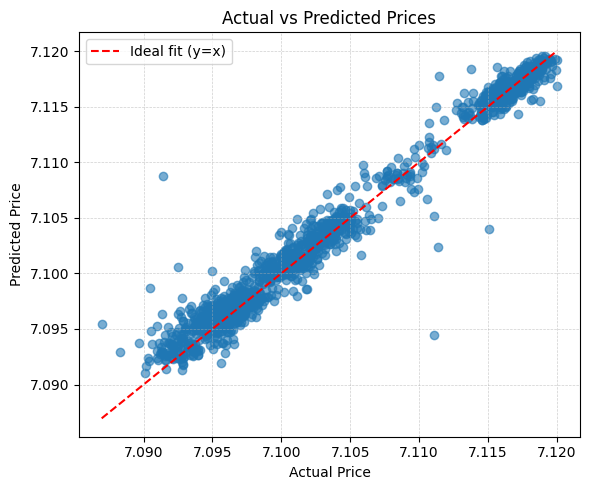

In [118]:
# Scatter plot of actual vs predicted
plt.figure(figsize=(6,5))
plt.scatter(y_test, pred, alpha=0.6)
x = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(x, x, color='red', linestyle='--', label='Ideal fit (y=x)')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

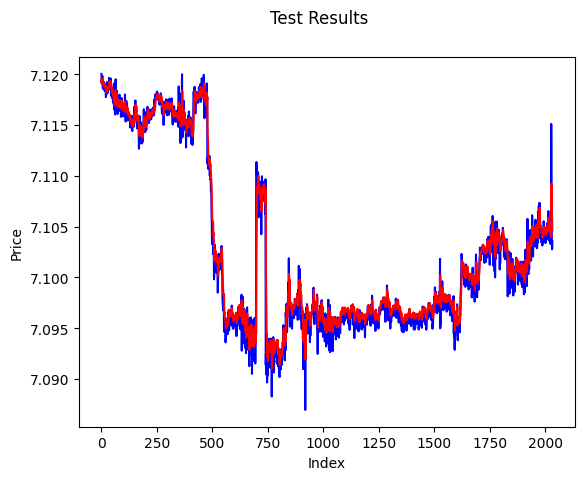

In [119]:
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Index')
plt.ylabel('Price')
plt.show()

## RNN: Empirical residual-based interval

In [122]:
# Calculate residuals on the test set
residuals = y_test - pred
sigma = np.std(residuals)  # standard deviation of residuals

# 95% prediction interval using normal approximation
z = 1.96  # 95% CI
lower = pred - z * sigma
upper = pred + z * sigma

pred  = pred[:, 0]
lower = lower[:, 0]
upper = upper[:, 0]

# Combine into DataFrame
miner_df = pd.DataFrame({
    "actual": y_test,
    "pred": pred,
    "lower_95": lower,
    "upper_95": upper
})

miner_df.head()


,actual,pred,lower_95,upper_95
0,7.120031,7.119159,7.095489,7.142829
1,7.119165,7.119573,7.095903,7.143243
2,7.119478,7.119288,7.095618,7.142958
3,7.119100,7.119399,7.095729,7.143069
4,7.119838,7.119291,7.095621,7.142961


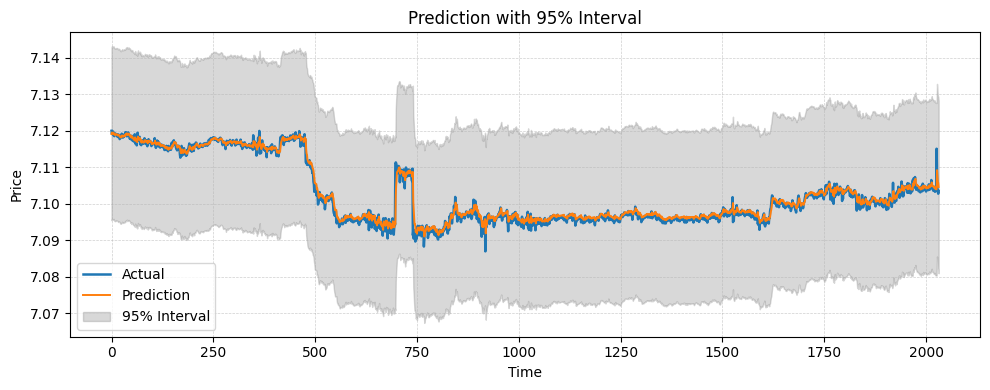

In [125]:
plt.figure(figsize=(10,4))
plt.plot(y_test, label="Actual", linewidth=1.8)
plt.plot(pred, label="Prediction", linewidth=1.4)
plt.fill_between(
    np.arange(len(pred)),
    lower,
    upper,
    color='gray',
    alpha=0.3,
    label="95% Interval"
)
plt.title("Prediction with 95% Interval")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

# LSTM

In [128]:
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model = Sequential()
model.add(LSTM(30, input_shape=(n_steps,n_features), activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=30,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=20,
          validation_split=0.2,
          verbose=1,
          callbacks=[es],
          shuffle=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,871 (15.12 KB)

 Trainable params: 3,871 (15.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9.9458 - mae: 1.7947 - val_loss: 1.8116e-06 - val_mae: 9.8487e-04
Epoch 2/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.4110e-05 - mae: 0.0029 - val_loss: 1.8923e-06 - val_mae: 0.0010
Epoch 3/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3566e-05 - mae: 0.0028 - val_loss: 2.4371e-06 - val_mae: 0.0012
Epoch 4/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4329e-05 - mae: 0.0029 - val_loss: 7.1088e-06 - val_mae: 0.0024
Epoch 5/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4666e-05 - mae: 0.0030 - val_loss: 5.0306e-06 - val_mae: 0.0019
Epoch 6/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.5081e-05 - mae: 0.0030 - val_loss: 2.2431e-06 - val_mae: 0.0011
Epoch 7/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5921e-05 - mae: 0.0031 - val_loss: 2.7983e-06 - val_mae: 0.0014
Epoch 8/500
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4861e-05 - mae: 0.0030 - val_loss: 3.0908e-06 - 

## LSTM results

In [129]:
# Predictions
pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Absolute Error (MAE): 0.001849
Mean Squared Error (MSE): 0.000007
Root Mean Squared Error (RMSE): 0.002586
R² Score: 0.910658


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 0.0018490804845975838


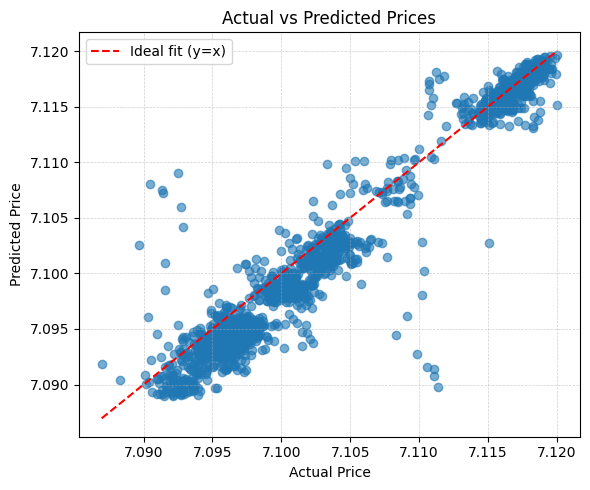

In [130]:
# Make predictions
pred = model.predict(X_test)

# Calculate MAE
print('MAE:', mean_absolute_error(y_test, pred))

# Scatter plot of actual vs predicted
plt.figure(figsize=(6,5))
plt.scatter(y_test, pred, alpha=0.6)
x = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(x, x, color='red', linestyle='--', label='Ideal fit (y=x)')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

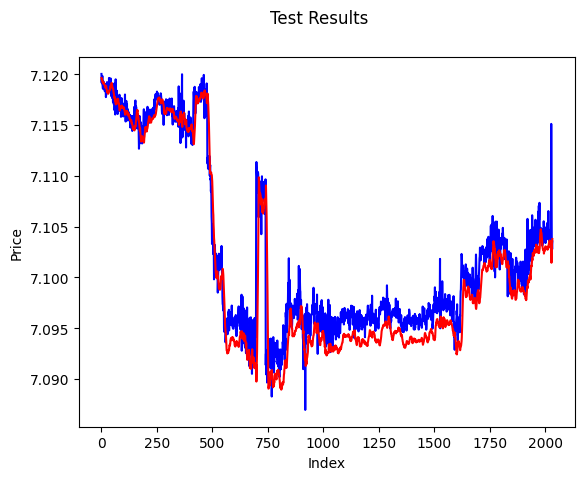

In [131]:
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Index')
plt.ylabel('Price')
plt.show()

## LSTM: Empirical residual-based interval

In [132]:
# Calculate residuals on the test set
residuals = y_test - pred
sigma = np.std(residuals)  # standard deviation of residuals

# 95% prediction interval using normal approximation
z = 1.96  # 95% CI
lower = pred - z * sigma
upper = pred + z * sigma

pred  = pred[:, 0]
lower = lower[:, 0]
upper = upper[:, 0]

# Combine into DataFrame
miner_df = pd.DataFrame({
    "actual": y_test,
    "pred": pred,
    "lower_95": lower,
    "upper_95": upper
})

miner_df.head()


,actual,pred,lower_95,upper_95
0,7.120031,7.119634,7.094679,7.144590
1,7.119165,7.119469,7.094513,7.144424
2,7.119478,7.119525,7.094570,7.144481
3,7.119100,7.119448,7.094492,7.144403
4,7.119838,7.119394,7.094438,7.144349


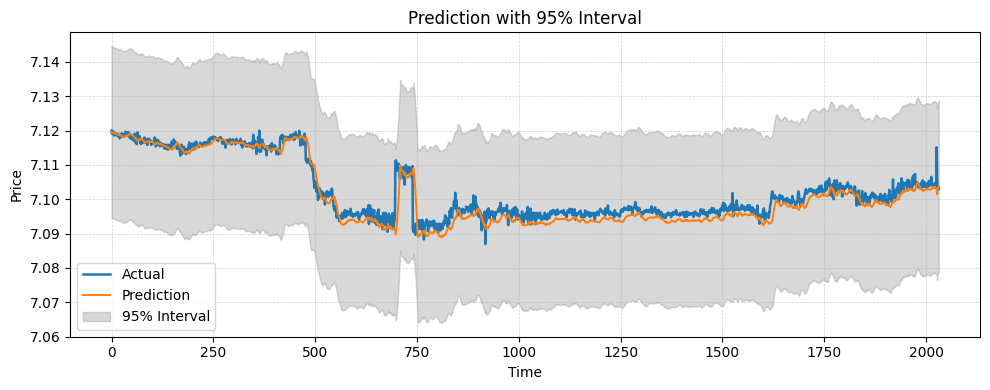

In [133]:
plt.figure(figsize=(10,4))
plt.plot(y_test, label="Actual", linewidth=1.8)
plt.plot(pred, label="Prediction", linewidth=1.4)
plt.fill_between(
    np.arange(len(pred)),
    lower,
    upper,
    color='gray',
    alpha=0.3,
    label="95% Interval"
)
plt.title("Prediction with 95% Interval")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

# Naive model baseline

## Naive forecast = assume the next price will be exactly the same as the most recent observed price.

In [134]:
print("Naive Forecasting Model")

# Naive prediction = last value in the input window
# X_test shape: (samples, n_steps, 1)
naive_pred = X_test[:, -1, 0]   # -1: the most recent price in the 12-step sequence.

Naive Forecasting Model


In [135]:
# Evaluate
naive_mae = mean_absolute_error(y_test, naive_pred)
naive_mse = mean_squared_error(y_test, naive_pred)
naive_rmse = np.sqrt(naive_mse)
naive_r2 = r2_score(y_test, naive_pred)

print(f"Naive MAE : {naive_mae:.6f}")
print(f"Naive MSE : {naive_mse:.6f}")
print(f"Naive RMSE: {naive_rmse:.6f}")
print(f"Naive R²  : {naive_r2:.6f}")

Naive MAE : 0.000851
Naive MSE : 0.000002
Naive RMSE: 0.001333
Naive R²  : 0.976271


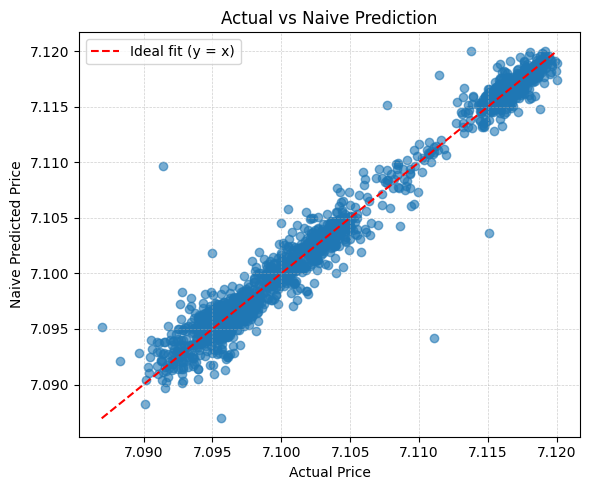

In [136]:
# Plot: Actual vs Naive
plt.figure(figsize=(6,5))
plt.scatter(y_test, naive_pred, alpha=0.6)
x = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(x, x, color='red', linestyle='--', label='Ideal fit (y = x)')
plt.title('Actual vs Naive Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Naive Predicted Price')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

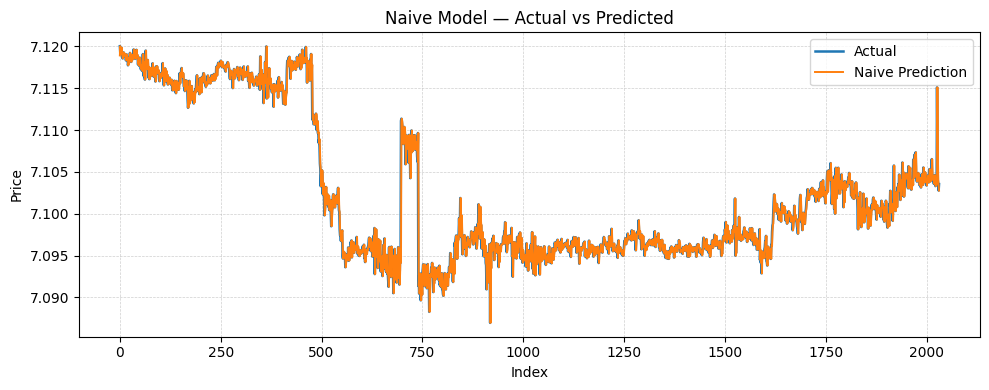

In [137]:
# Timeline plot
plt.figure(figsize=(10,4))
plt.plot(y_test, label="Actual", linewidth=1.8)
plt.plot(naive_pred, label="Naive Prediction", linewidth=1.4)
plt.title("Naive Model — Actual vs Predicted")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()